## Clustering and Dimensionality on World COVID-19 Data

### Requirements:
* pandas
* sklearn
* pydantic
* requests
* covid
* matplotlib
* numpy

May need to install each module with following command:
sudo python3 -m pip install *module_name*
Covid Data from https://github.com/ahmednafies/covid

In [201]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

from covid import Covid
# to get data from worldometers.info
covid = Covid(source="worldometers")


In [202]:
# example of some commands that can be run on data
active = covid.get_total_active_cases()

confirmed = covid.get_total_confirmed_cases()

recovered = covid.get_total_recovered()

deaths = covid.get_total_deaths()

#### Now we have the data, we want to read it as a data frame so we can perform clustering and dimensionality reduction algorithms

We set the 'country' as the index, so that each row has only numeric data and is identified by the country. \

We don't want to include new_cases and new_deaths data, as these vary depending on time of day code is run. We also want to only gather data for countries, not continents. 

In [215]:
covid_df = pd.DataFrame(covid.get_data())

# we don't want world or continent data
covid_df = covid_df.set_index('country')
covid_df.drop(columns=['new_cases', 'new_deaths', 'total_tests_per_million'], inplace=True)
covid_df.drop(['Asia', 'Africa', 'North America', 'South America', 'Europe', 'Oceania', 'World', '0'], axis=0, inplace=True)

# More Data pruning, remove if 0 tests, and < 1000
covid_df.drop(covid_df[covid_df['total_tests'] < 2].index, inplace=True)
covid_df.drop(covid_df[covid_df['confirmed'] < 1000].index, inplace=True)

# From previous PCA runs, USA, India, Russia China are outliers, so lets experiment with removing them
covid_df.drop(['USA', 'India', 'Russia', 'China'], axis=0, inplace=True)

# preview data
print(covid_df.head())

              confirmed  deaths  recovered  active  critical  total_tests  \
country                                                                     
Brazil          1970909   75523    1255564  639822      8318      4572796   
Peru             337724   12417     226400   98907      1325      1983932   
Chile            321205    7186     292085   21934      1915      1334712   
Mexico           317635   36906     199129   81600       378       768457   
South Africa     311049    4453     160693  145903       539      2278127   

             total_cases_per_million total_deaths_per_million population  
country                                                                   
Brazil                          9270                      355  212620008  
Peru                           10238                      376   32988703  
Chile                          16797                      376   19122661  
Mexico                          2463                      286  128984785  
South Afri

In [216]:
def find_cluster(min_clusters, max_clusters, df):
    kmeans_performance = []

    for k in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=k)
        clusters = kmeans.fit(covid_df)
        kmeans_performance.append(kmeans.inertia_)
    
    # add min_clusters to offset 0-indexing
    optimal_k = min_clusters + kmeans_performance.index(max(kmeans_performance))
    # re-create optimal kmeans clustering and plot
    kmeans_best = KMeans(n_clusters=optimal_k)
    clusters = kmeans_best.fit(df)
    return clusters, optimal_k

In [230]:
# Perform clustering before PCA, for comparison
kmeans_performance = []
min_clusters = 4
max_clusters = 8

HD_clusters = find_cluster(4, 8, covid_df)
clustered_data = pd.DataFrame(index=covid_df.index)

clustered_data['HD_cluster'] = pd.Series(clusters.labels_, index=covid_df.index)

#### Dimensionality reduction with PCA

We want to represent the COVID data of each country in a two-dimensional space. Currently, each country has 13 features, such as deaths, recovered etc. We will use a PCA implementation by python's sklearn module. 

This follow tutorial found at https://www.codementor.io/@jadianes/data-science-python-pandas-r-dimensionality-reduction-du1081aka


In [232]:
pca = PCA(n_components=2)

pca.fit(covid_df)

covid_2d = pca.transform(covid_df)

covid_df_2d = pd.DataFrame(covid_2d)

# To use for later kmeans
covid_df_DR = covid_df_2d

covid_df_2d.index = covid_df.index

covid_df_2d.columns = ['PC1','PC2']

covid_df_2d.head()

# Want to find contribution of each feature to PCA

#loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=iris.feature_names)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=covid_df.columns)

print("Components of 2D Data")
print(loadings) 

Components of 2D Data
                                   PC1       PC2
confirmed                 2.001517e-03  0.040497
deaths                    9.223872e-05  0.003567
recovered                 1.234430e-03  0.018538
active                    6.316602e-04  0.004225
critical                  8.165398e-06  0.000121
total_tests               1.061339e-02  0.998935
total_cases_per_million  -1.345068e-05  0.000506
total_deaths_per_million  2.399110e-07  0.000055
population                9.999407e-01 -0.010710


#### Now we can Plot the Lower Dimensional Representation of our data

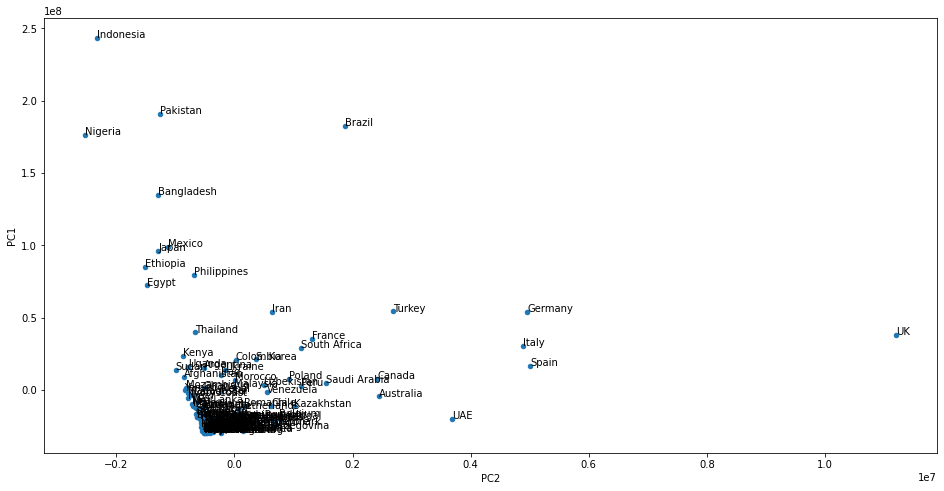

In [219]:
%matplotlib inline
    
ax = covid_df_2d.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))
    
for i, country in enumerate(covid_df.index):
    ax.annotate(
        country, 
        (covid_df_2d.iloc[i].PC2, covid_df_2d.iloc[i].PC1)
    )

### Now, we want to use Cluster countries according to Dimension-Reduced COVID data

We will again use k-means clustering with different values of k to see which is optimal. This time, we will pass in 2-dimensional data to find clusters.

Clustering of Countries before and after PCA is the same


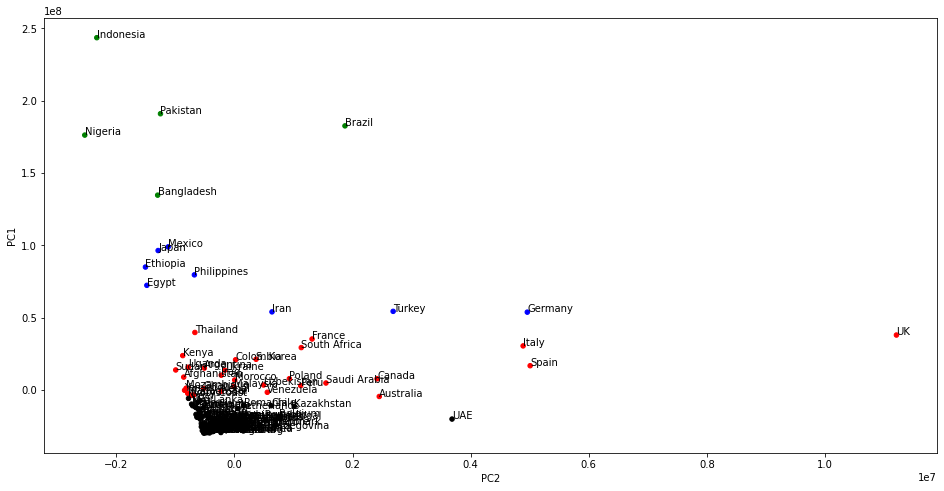

In [228]:
DR_clusters, k = find_cluster(4, 8, covid_df_2d)
clustered_2d_data = covid_df_2d.copy()
clustered_2d_data['cluster'] = pd.Series(DR_clusters.labels_, index=covid_df_2d.index)

# Map clusters to colors instead of grayscale
clustered_2d_data.cluster = clustered_2d_data.cluster.map({0:'k', 1: 'g', 2: 'b', 3:'r', 4:'m', 5:'c', 6:'y', 7:'w'})

cluster_plot = clustered_2d_data.plot(kind='scatter',x='PC2',y='PC1', c=clustered_2d_data.cluster, figsize=(16,8))
for i, country in enumerate(covid_df.index):
    cluster_plot.annotate(
        country, 
        (covid_df_2d.iloc[i].PC2, covid_df_2d.iloc[i].PC1)
    )

# Compare These Clusters to original higher dimensional kmeans clustering
clustered_data['2D_cluster'] = pd.Series(DR_clusters.labels_, index=covid_df_2d.index)

# See if grouping of countries is different before and after PCA
# Create two unordered sets and compare grouping of countries
cluster_grouping_2D = set()
cluster_grouping_HD = set()

for cluster_number in range(0, k):
    cluster_grouping_2D.add(frozenset(clustered_data[clustered_data['2D_cluster'] == cluster_number].index))
    cluster_grouping_HD.add(frozenset(clustered_data[clustered_data['HD_cluster'] == cluster_number].index))

if(cluster_grouping_HD == cluster_grouping_2D):
    print("Clustering of Countries before and after PCA is the same")
else:
    print("PCA has changed the clustering of Countries as follows:")
    

#### We can also plot a bubble chart with data point size proportional to total number of cases of that country.

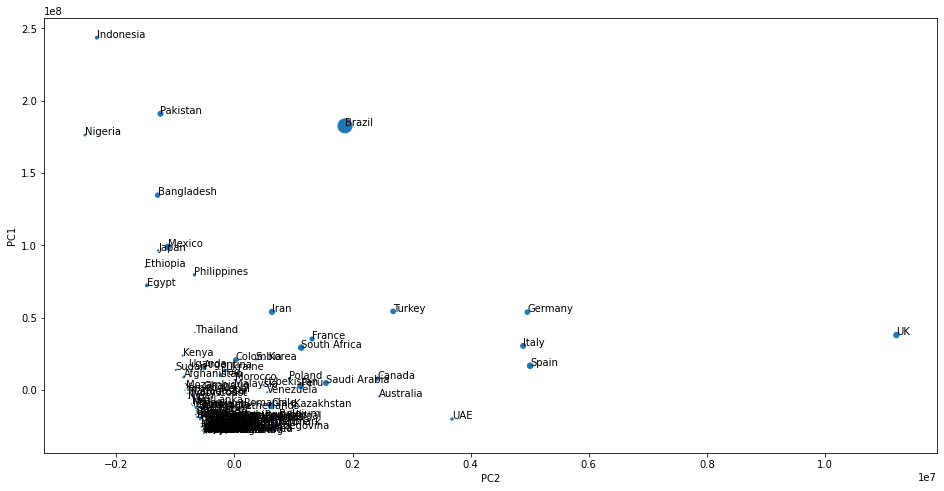

In [229]:
covid_df_2d['confirmed'] = covid_df['confirmed']

bubble = covid_df_2d.plot(kind='scatter', x='PC2', y='PC1', s=covid_df_2d['confirmed']/10000, figsize=(16,8))
    
for i, country in enumerate(covid_df.index):
    bubble.annotate(
        country, 
        (covid_df_2d.iloc[i].PC2, covid_df_2d.iloc[i].PC1)
    )